In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import seaborn as sns
import math

## Image loading and resizing

In [2]:
n_points = 60

In [3]:
#img = cv.imread('wire.jpg')
img = cv.imread('../Data/e.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img = cv.resize(img, (400, 400))

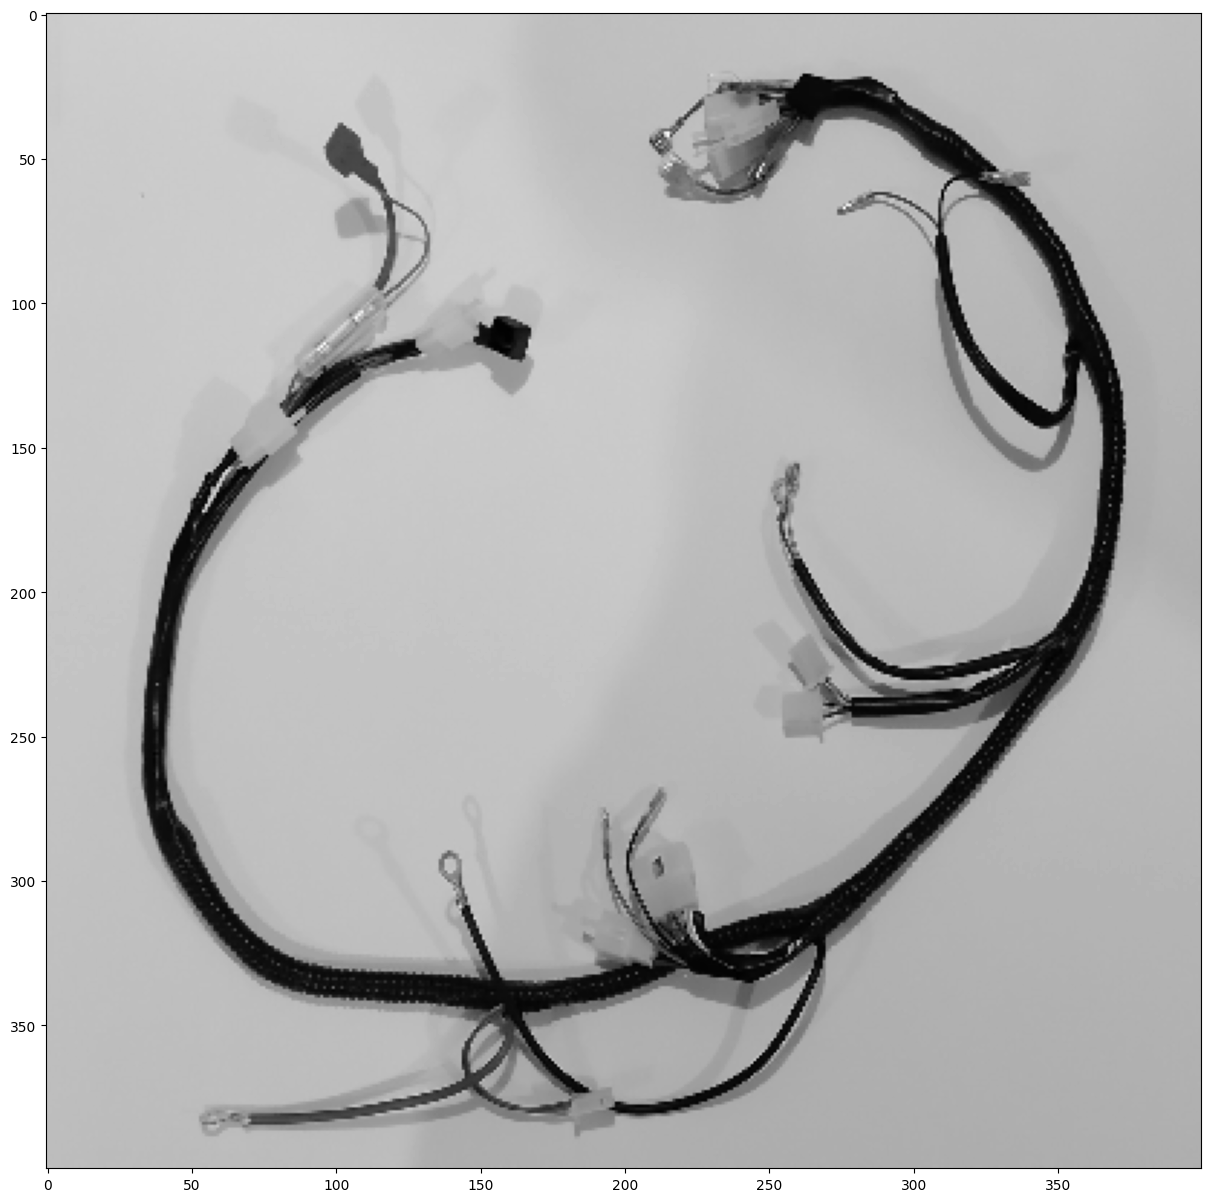

In [4]:
plt.subplots(figsize=(15,15)),plt.imshow(img, 'gray', vmin=0, vmax=255)
plt.show()

## Binary thresholding

In [5]:
# Apply thresholding to conserve only pixels below 100 (close to black)
_, binary_mask = cv.threshold(img,100,255,cv.THRESH_BINARY)

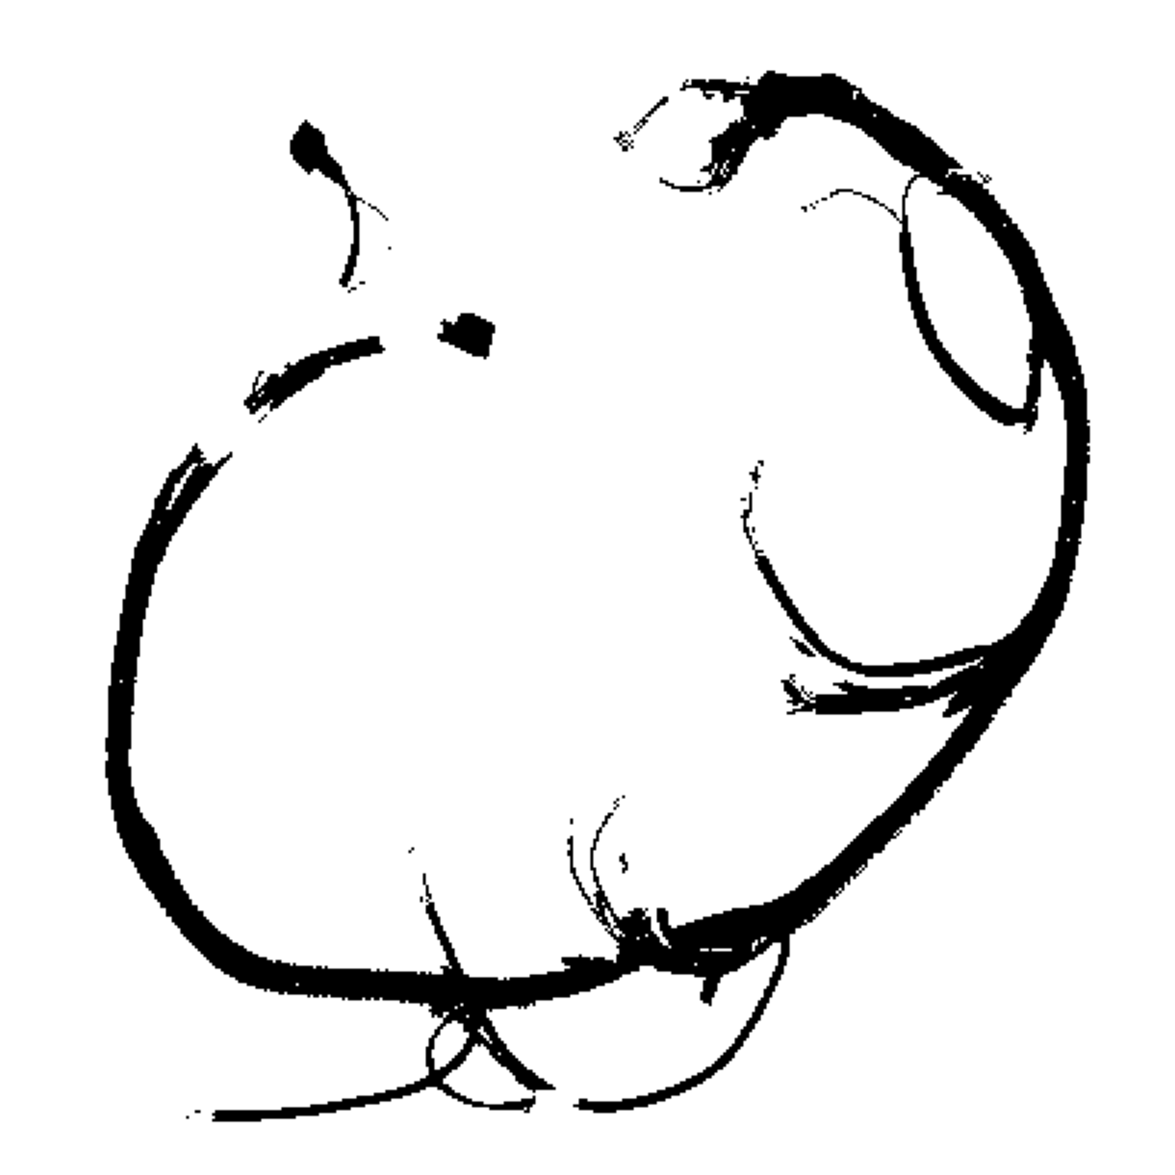

In [6]:
plt.subplots(figsize=(15,15)),plt.imshow(binary_mask, 'gray')
plt.axis('off')
plt.show()

In [7]:
# Transforming the resulting binari mask into a list of points where rows=Y and cols=X
rows, cols = np.where(binary_mask == 0)
points = np.column_stack((rows, cols))

In [8]:
points.shape

(12732, 2)

## Aglomerative clustering

In [9]:
knn_graph = kneighbors_graph(points, n_points, include_self=False)

In [10]:
clustering = AgglomerativeClustering(n_clusters=n_points, linkage="ward", connectivity=knn_graph)

In [11]:
clustering.fit(points)

c:\Python310\lib\site-packages\sklearn\cluster\_agglomerative.py:282: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


AgglomerativeClustering(connectivity=<12732x12732 sparse matrix of type '<class 'numpy.float64'>'
	with 763920 stored elements in Compressed Sparse Row format>,
                        n_clusters=60)

In [12]:
clustering.labels_

array([16, 16, 16, ..., 18, 18, 18], dtype=int64)

In [13]:
df = pd.DataFrame(points)
df['cluster'] = clustering.labels_
df.columns = ['Y', 'X', 'clusters']
df['Y'] = (df['Y'] * (-1)) + 400

In [14]:
df

,Y,X,clusters
0,379,262,16
1,379,263,16
2,379,264,16
3,378,261,16
4,378,262,16
...,...,...,...
12727,16,82,18
12728,16,83,18
12729,16,84,18
12730,16,85,18


In [15]:
df['clusters'].unique()

array([16, 11,  5, 33, 40,  1, 23, 31, 20, 27, 58, 25,  2, 19, 13, 54, 26,
       47, 43, 29, 30,  4, 28, 57, 32, 46, 50,  7, 48,  0,  8, 35, 59,  6,
       41, 21, 42, 24, 51, 49, 37, 52, 17, 38,  3, 15,  9, 45, 14, 36, 12,
       44, 53, 10, 55, 39, 22, 34, 56, 18], dtype=int64)

(0.0, 400.0, 0.0, 400.0)

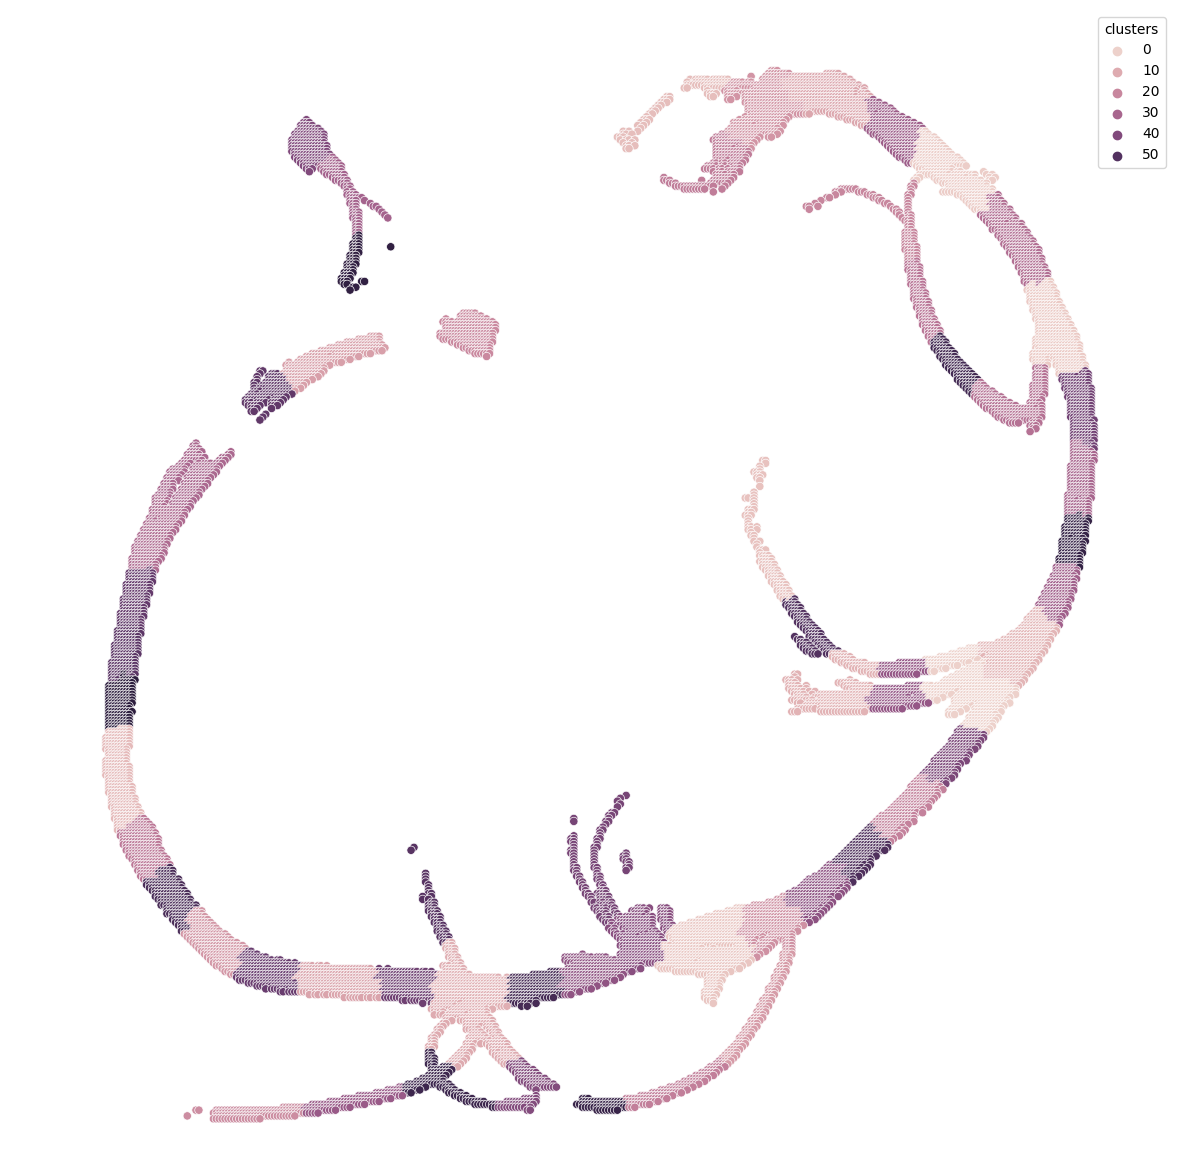

In [16]:
fig,ax = plt.subplots(figsize=(15,15))
sns.scatterplot(data=df, x="X", y='Y', hue="clusters", ax=ax)
_=ax.set_xlim(0,400)
_=ax.set_ylim(0,400)
plt.axis('off')

## Grip points calculation

In [17]:
df_points = df.groupby('clusters').agg({'X':[np.mean], 'Y':[np.mean]}).reset_index()

In [18]:
df_points.columns = ['clusters', 'X', 'Y']
df_points = df_points.apply(round)
df_points['Y'] = df_points['Y']

Now we round each point out of the wire area to its nearest neighbor point.

In [19]:
points_list = list(df_points[['X', 'Y']].itertuples(index=False, name=None))

In [20]:
rounded_points = 0  # Counter for the number of rounded points (necessary for the accuracy metric calculated later)
for i in range(len(points_list)):       # Rounds each centroid point to the nearest point on its cluster
    cluster_df = df.loc[df['clusters'] == i]
    cluster_list = list(cluster_df[['X', 'Y']].itertuples(index=False, name=None))
    if points_list[i] not in cluster_list:
        dist_list = []
        for pt in cluster_list:
            dist_list.append(math.dist(points_list[i], pt))
        idx = dist_list.index(min(dist_list))
        points_list[i] = cluster_list[idx]
        rounded_points += 1

Then it's time for sorting the points in order to get an end-to-end trajectory along the cable.

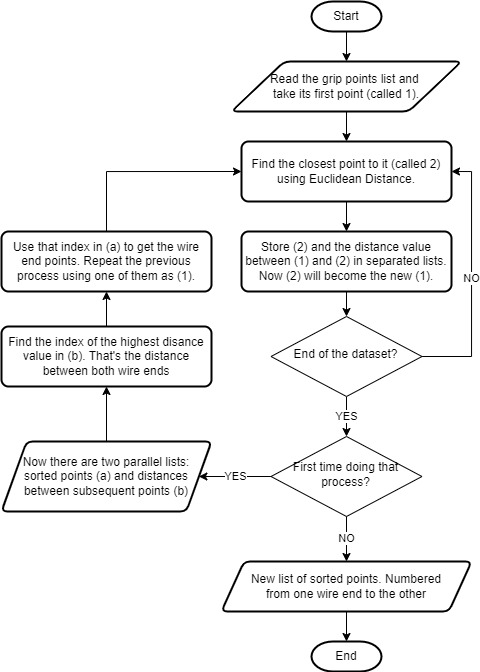

In [21]:
list_sorted = [points_list[0]]  # This will be the list containing the first iteration of the sorting algorithm.
points_list.remove(points_list[0])

In [22]:
# Now we will find the nearest point of each in "list_sorted" until "points_list" gets emptied.
flag = True

while flag:
    point1 = list_sorted[-1]
    distances = []
    points = []
    
    for point2 in points_list:
        distance = math.dist(point1, point2)    # 
        distances.append(distance)
        points.append(point2)
        
    min_dist_1 = min(distances)
    min_idx_1 = distances.index(min_dist_1)
    
    list_sorted.append(points[min_idx_1])
    points_list.remove(points[min_idx_1])
    
    if not points_list:
        flag = False

In [23]:
# Then we calculate the distance between each subsequent point and store them in a list parallel to "list_sorted"
distances_list = [] 
for i in range(len(list_sorted)):
    if not i == (len(list_sorted) - 1):
        dist = math.dist(list_sorted[i], list_sorted[i+1])
        distances_list.append(dist)

In [24]:
# A threhold is defined for obtaining the largest distance between subsequent points. That will be the one between ends of the wire.
distances = pd.Series(distances_list.copy())
threshold = distances.mean() + distances.std()
threshold

69.85001664792412

In [25]:
first_pt_idx = distances_list.index(distances.loc[distances > threshold].iloc[0])
print("Distance between ends: ", first_pt_idx)
print("Coordinates of one end: ", list_sorted[first_pt_idx])

Distance between ends:  15
Coordinates of one end:  (227, 369)


In [26]:
# We take that end-point and perform the second iteration of the sorting algorithm same as before.
list_sorted2 = [list_sorted[first_pt_idx]]
list_sorted.remove(list_sorted[first_pt_idx])

In [27]:
flag = True

while flag:
    point1 = list_sorted2[-1]
    distances = []
    points = []
    
    for point2 in list_sorted:
        distance = math.dist(point1, point2)
        distances.append(distance)
        points.append(point2)
        
    min_idx_1 = distances.index(min(distances))
    
    list_sorted2.append(points[min_idx_1])
    list_sorted.remove(points[min_idx_1])
    
    if not list_sorted:
        flag = False

In [28]:
df_points = pd.DataFrame(list_sorted2, columns=['X', 'Y'])  # "list_sorted2" contains the final points sorted as a trajectory along the cable.

Here is the plot of the result for the current image loaded.

(0.0, 400.0, 0.0, 400.0)

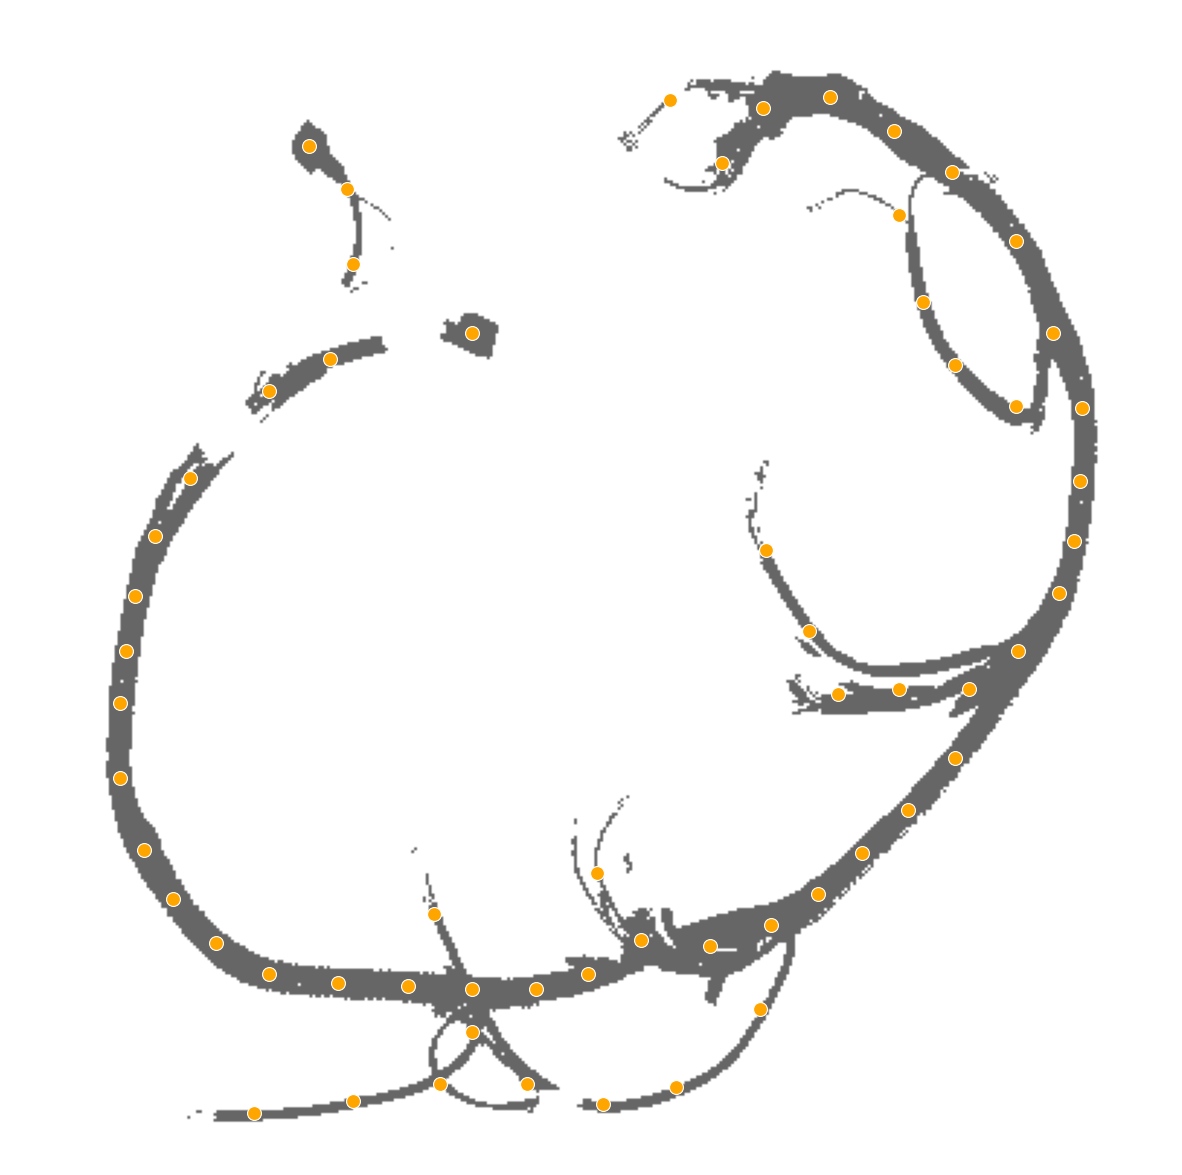

In [29]:
fig,ax = plt.subplots(figsize=(15,15))
plt.xlim(0, 400)
plt.ylim(0, 400)
#plt.axis('off')
sns.scatterplot(data=df_points, x="X", y='Y', ax=ax, color='orange', s=100)
ax.imshow(binary_mask, extent=[0, 400, 0, 400], aspect='auto', alpha=0.6, cmap='gray')
#plt.tick_params(labelsize=30)
plt.axis('off')
#plt.savefig('../Data/sample results/1.jpg')

## Algorithm evaluation

In [30]:
rounded_points

9

In [31]:
n_points

60

In [32]:
accuracy = (n_points - rounded_points)/n_points
print("The accuracy of the algorithm for the curren image is: ", accuracy)

The accuracy of the algorithm for the curren image is:  0.85
